<h1>Predict Customer Spending Score</h1>
<h3>-> Low: 0, Average: 1, High: 2</h3>

In [53]:
### Data Preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Combine CSVs
csv1 = pd.read_csv("drive/My Drive/Colab Notebooks/Predict Customer Spending Score/Test.csv")
csv2 = pd.read_csv("drive/My Drive/Colab Notebooks/Predict Customer Spending Score/Customers.csv")

dataframe = pd.concat( [csv1, csv2], ignore_index = True )
dataframe = dataframe.drop(["ID", "Segmentation", "Var_1"] , axis = 1)
dataframe

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Female,Yes,36,Yes,Engineer,0.0,Low,1.0
1,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0
2,Female,Yes,69,No,NaN,0.0,Low,1.0
3,Male,Yes,59,No,Executive,11.0,High,2.0
4,Female,No,19,No,Marketing,NaN,Low,4.0
...,...,...,...,...,...,...,...,...
10690,Male,No,22,No,NaN,0.0,Low,7.0
10691,Male,No,35,No,Executive,3.0,Low,4.0
10692,Female,No,33,Yes,Healthcare,1.0,Low,1.0
10693,Female,No,27,Yes,Healthcare,1.0,Low,4.0


In [54]:
# Fill na with mode
ever_married_mode = dataframe['Ever_Married'].mode()[0]
dataframe['Ever_Married'] = dataframe['Ever_Married'].fillna(ever_married_mode)

graduated_mode = dataframe['Graduated'].mode()[0]
dataframe['Graduated'] = dataframe['Graduated'].fillna(graduated_mode)

Profession_mode = dataframe['Profession'].mode()[0]
dataframe['Profession'] = dataframe['Profession'].fillna(Profession_mode)

# Fill na with mean
Work_Experience_mean = int(dataframe['Work_Experience'].mean())
dataframe['Work_Experience'] = dataframe['Work_Experience'].fillna(Work_Experience_mean)

Family_Size_mean = int(dataframe['Family_Size'].mean())
dataframe['Family_Size'] = dataframe['Family_Size'].fillna(Family_Size_mean)

In [55]:
# label encode categorical data
dataframe['Gender'] = dataframe['Gender'].map({'Male': 1, 'Female': 0})
dataframe['Ever_Married'] = dataframe['Ever_Married'].map({'Yes': 1, 'No': 0})
dataframe['Graduated'] = dataframe['Graduated'].map({'Yes': 1, 'No': 0})
dataframe['Spending_Score'] = dataframe['Spending_Score'].map({'Low': 0, 'Average': 1, 'High': 2})

# One Hot Encoding
profession_dummies = pd.get_dummies(dataframe['Profession'], prefix='Profession', prefix_sep='=>', dtype=int)
dataframe = pd.concat([dataframe, profession_dummies], axis = 1)

dataframe = dataframe.drop('Profession', axis = 1)

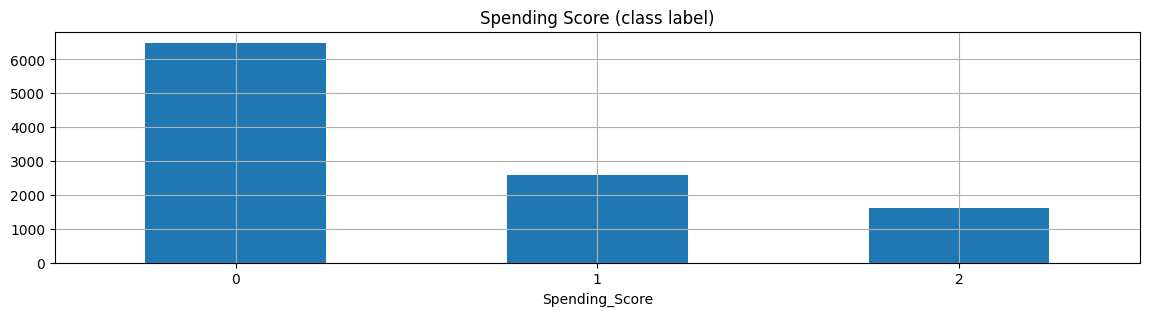

In [56]:
dataframe['Spending_Score'].value_counts().plot(kind='bar', title='Spending Score (class label)', rot=0, grid=True, figsize=(14, 3))
plt.show()

In [57]:
# categorical_columns = list(dataframe.columns)
# categorical_columns.remove('Age')
# categorical_columns.remove('Work_Experience')
# categorical_columns.remove('Family_Size')
# categorical_columns.remove('Spending_Score')

# continuous_columns = ['Family_Size', 'Work_Experience', 'Age']

# for column in continuous_columns:
#   plt.figure()
#   dataframe[column].plot(kind='box', title=column, rot=0, figsize=(15, 3))
#   plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


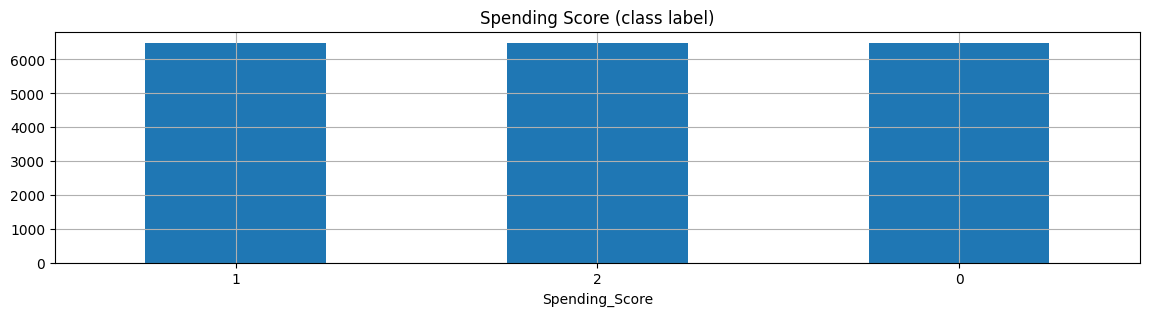

Features: (19486, 15)
Label: (19486,)


In [58]:
from imblearn.over_sampling import KMeansSMOTE

# Separate data
features = dataframe.drop('Spending_Score', axis = 1)
label = dataframe['Spending_Score']

# Balance Data
over_sampler = KMeansSMOTE()
features, label = over_sampler.fit_resample(features, label)

label.value_counts().plot(kind='bar', title='Spending Score (class label)', rot=0, grid=True, figsize=(14, 3))
plt.show()

print(f"Features: {features.values.shape}\nLabel: {label.values.shape}")

In [59]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split Data
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size = 0.3, stratify=label.values, random_state=42)

# Apply Feature Scaling
training_scaler = StandardScaler()
testing_scaler = StandardScaler()

X_train = training_scaler.fit_transform(X_train)
X_test = testing_scaler.fit_transform(X_test)

# Change to tensors
X_train = tf.cast(X_train, dtype=tf.float32)
X_test = tf.cast(X_test, dtype=tf.float32)
y_train = tf.cast(y_train, dtype=tf.float32)
y_test = tf.cast(y_test, dtype=tf.float32)

print(X_train.shape, X_train.dtype)
print(X_test.shape, X_test.dtype)

(13640, 15) <dtype: 'float32'>
(5846, 15) <dtype: 'float32'>


In [76]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

TensorFlow_model = Sequential([
  Dense(units=120, activation='relu'),
  Dropout(rate=0.2),

  Dense(units=60, activation='relu'),
  Dropout(rate=0.2),

  Dense(units=30, activation='relu'),
  Dense(units=3, activation='softmax')
])

stopper = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=False, patience=10, start_from_epoch=10)

TensorFlow_model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])

training = TensorFlow_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose = 1, validation_split=0.25, callbacks=[stopper])

testing = TensorFlow_model.evaluate(X_test, y_test)

Epoch 1/100
320/320 [==============================] - 4s 7ms/step - loss: 0.5119 - sparse_categorical_accuracy: 0.8149 - val_loss: 0.3735 - val_sparse_categorical_accuracy: 0.8677
Epoch 2/100
320/320 [==============================] - 1s 4ms/step - loss: 0.3920 - sparse_categorical_accuracy: 0.8663 - val_loss: 0.3540 - val_sparse_categorical_accuracy: 0.8798
Epoch 3/100
320/320 [==============================] - 1s 4ms/step - loss: 0.3630 - sparse_categorical_accuracy: 0.8754 - val_loss: 0.3490 - val_sparse_categorical_accuracy: 0.8815
Epoch 4/100
320/320 [==============================] - 1s 4ms/step - loss: 0.3598 - sparse_categorical_accuracy: 0.8783 - val_loss: 0.3394 - val_sparse_categorical_accuracy: 0.8865
Epoch 5/100
320/320 [==============================] - 1s 4ms/step - loss: 0.3521 - sparse_categorical_accuracy: 0.8807 - val_loss: 0.3357 - val_sparse_categorical_accuracy: 0.8877
Epoch 6/100
320/320 [==============================] - 1s 4ms/step - loss: 0.3439 - sparse_cate

Training Accuracy:    0.8149
Training Loss:        0.5119

Validation Accuracy:  0.8677
Validation Loss:      0.3735

Testing Accuracy:     0.8888
Testing Loss:         0.3248


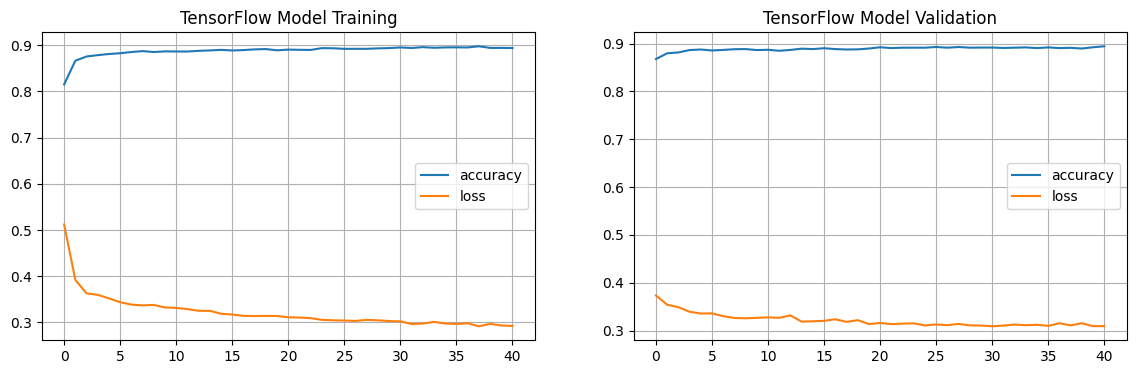

In [77]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14,4))

# Helper function
def plot_curve(axis, accuracy, loss, title):
  axis.plot(accuracy)
  axis.plot(loss)
  axis.legend(['accuracy', 'loss'])
  axis.grid(True)
  axis.set_title(title)

print(f"Training Accuracy:    {training.history['sparse_categorical_accuracy'][0]:.4f}")
print(f"Training Loss:        {training.history['loss'][0]:.4f}\n")
print(f"Validation Accuracy:  {training.history['val_sparse_categorical_accuracy'][0]:.4f}")
print(f"Validation Loss:      {training.history['val_loss'][0]:.4f}\n")
print(f"Testing Accuracy:     {testing[1]:.4f}")
print(f"Testing Loss:         {testing[0]:.4f}")


plot_curve(axis=ax[0], accuracy=training.history['sparse_categorical_accuracy'],  loss=training.history['loss'], title="TensorFlow Model Training")
plot_curve(axis=ax[1], accuracy=training.history['val_sparse_categorical_accuracy'],  loss=training.history['val_loss'], title="TensorFlow Model Validation")

plt.show()